# Calculating the reactor neutrino flux
We use fission fractions and average released energy
for each nuclear reactor isotope from https://arxiv.org/abs/1212.6625 combined with the antineutrino spectra parameterisation from https://arxiv.org/abs/1101.2663. The flux is calculated using the code in src/NeutrinoFuncs.py. This notebook is for calculating the flux, tabulating the data and checking it with a plot.

The list of nearby reactors for Boulby and GranSasso are in src/Params.py

Norm =  3059992.586655093
E_nu_max =  11.418
Norm =  89816386.17168213


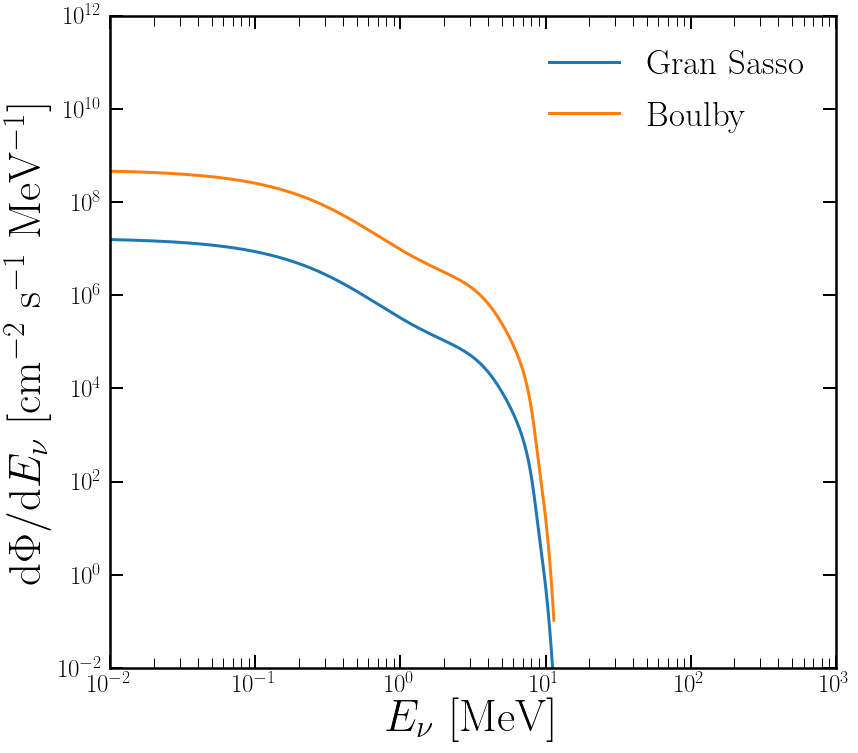

In [11]:
import sys
sys.path.append('../src')
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from Params import *
from LabFuncs import *
from PlotFuncs import *
from NeutrinoFuncs import *

NuclearReactors

fig,ax = MySquarePlot(r'$E_\nu$ [MeV]',r'$\textrm{d}\Phi/\textrm{d}E_\nu$ [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')

# GranSasso
E_nu = logspace(-2,log10(1.1418e1),1000)
F = ReactorFlux(E_nu,GranSasso)
Fnorm = trapz(F,E_nu)
print('Norm = ',Fnorm)
print('E_nu_max = ',amax(E_nu[F>0]))
plt.loglog(E_nu,F,'-',lw=3,label='Gran Sasso')
savetxt(nufile_dir+'reactor/ReactorAntiNu-GranSasso.txt',vstack((E_nu,F)).T)
savetxt(nufile_dir+'Reactor-1000.txt',vstack((E_nu,F/Fnorm)).T,delimiter=',') # Use Reactor for likelihood analysis so save it here

# Boulby
F = ReactorFlux(E_nu,Boulby)
Fnorm = trapz(F,E_nu)
print('Norm = ',Fnorm)
plt.loglog(E_nu,F,'-',lw=3,label='Boulby')
savetxt(nufile_dir+'reactor/ReactorAntiNu-GranSasso.txt',vstack((E_nu,F)).T)

plt.legend(frameon=False,fontsize=35)
plt.ylim([1e-2,1e12])
plt.xlim([1e-2,1e3])

plt.show()
MySaveFig(fig,'ReactorAntiNu')

In [8]:
F

array([4.57895098e+08, 4.57650209e+08, 4.57403603e+08, 4.57155270e+08,
       4.56905200e+08, 4.56653380e+08, 4.56399801e+08, 4.56144451e+08,
       4.55887319e+08, 4.55628394e+08, 4.55367665e+08, 4.55105120e+08,
       4.54840748e+08, 4.54574538e+08, 4.54306479e+08, 4.54036558e+08,
       4.53764765e+08, 4.53491087e+08, 4.53215514e+08, 4.52938034e+08,
       4.52658634e+08, 4.52377303e+08, 4.52094030e+08, 4.51808803e+08,
       4.51521609e+08, 4.51232437e+08, 4.50941274e+08, 4.50648109e+08,
       4.50352930e+08, 4.50055724e+08, 4.49756479e+08, 4.49455183e+08,
       4.49151824e+08, 4.48846390e+08, 4.48538867e+08, 4.48229244e+08,
       4.47917509e+08, 4.47603648e+08, 4.47287649e+08, 4.46969499e+08,
       4.46649187e+08, 4.46326699e+08, 4.46002022e+08, 4.45675144e+08,
       4.45346052e+08, 4.45014732e+08, 4.44681173e+08, 4.44345362e+08,
       4.44007284e+08, 4.43666928e+08, 4.43324280e+08, 4.42979327e+08,
       4.42632056e+08, 4.42282453e+08, 4.41930507e+08, 4.41576202e+08,
      

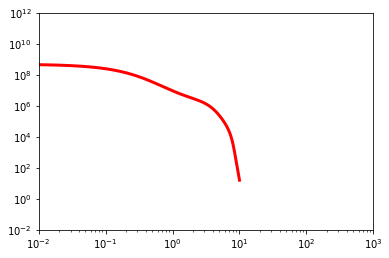

In [15]:
import time
from numpy import *
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.colors as colors
from Params import *
from LabFuncs import *
from PlotFuncs import *
    
def ReactorFlux(E_nu,Loc):
    # Following https://arxiv.org/abs/1812.05550, using the 
    # Constants 
    U235_c = array([3.217,-3.111,1.395,-0.3690,0.04445,-0.002053])
    U238_c = array([0.4833,0.1927,-0.1283,-0.006762,0.00233,-0.0001536])
    P239_c = array([6.413,-7.432,3.535,-0.8820,0.1025,-0.00455])
    P241_c = array([3.251,-3.204,1.428,-0.3675,0.04245,-0.001896])

    def Sk(coeff,E_nu):
        Sk = exp(coeff[0]
                 +coeff[1]*E_nu**1.0
                 +coeff[2]*E_nu**2.0
                 +coeff[3]*E_nu**3.0
                 +coeff[4]*E_nu**4.0
                 +coeff[5]*E_nu**5.0)
        return Sk
    
    NearbyReactors = Loc.NearbyReactors
    A = asarray(list(NearbyReactors_Boulby.values()))
    Powers = A[:,0]
    Coors = A[:,1:]
    
    R = 6371e3
    phi1 = Loc[0]*pi/180.0
    phi2 = Coords[:,0]*pi/180.0
    dphi = phi1-phi2
    dlambda = (Loc[1]-Coords[:,1])*pi/180.0
    a = sin(dphi/2)**2.0 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2.0
    bearing = 2*arctan2(sqrt(a),sqrt(1-a))
    Distances = 2*R*sin(bearing/2.0)

    fk = array([0.58,0.07,0.3,0.05])
    Ek = array([202.36,205.99,211.12,214.26])
    phi = fk[0]*Sk(U235_c,E_nu) 
    phi += fk[1]*Sk(U238_c,E_nu) 
    phi += fk[2]*Sk(P239_c,E_nu) 
    phi += fk[3]*Sk(P241_c,E_nu) 
    
    Phi = 0.0
    for i in range(0,size(Distances)):
        Phi += phi*(Powers[i]/(1.6e-19))*(6.0*0.75/sum(fk*Ek))/(4*pi*(Distances[i]*100)**2.0)
    return Phi


# From https://en.wikipedia.org/wiki/List_of_nuclear_reactors
# Dictionary = Power,latitude,longitude
NearbyReactors_Boulby = {'Hartlepool': [1310.0,54.640268, -1.191826],
                        'Heynsham': [2610.0,54.030124,-2.915303 ],
                        'Hunterston': [1288.0,55.722970, -4.891329],
                        'Unknown': [1364.0,55.722970 ,-2.406619]
                        'Torness': [1250.0,55.969103, -2.406619],
                        'Sizewell': [1310.0,52.213361, 1.619662],
                        'Dungeness': [1230.0,50.913796, 0.959705]}
# Powers_Boulby = array([1310.0,2610.0,1288.0,1364.0,1250.0,1310.0,1230.0])
# Coords_Boulby = array([[54.640268, -1.191826],
#                [54.030124, -2.915303],
#                [55.722970, -4.891329],
#               [55.969103, -2.406619],
#               [52.213361, 1.619662],
#               [50.913796, 0.959705]])


E_nu = logspace(-2,1.0,1000)
F = ReactorFlux(E_nu,Loc,Coords,Powers)
plt.loglog(E_nu,F,'r-',lw=3)

plt.ylim([1e-2,1e12])
plt.xlim([1e-2,1e3])

savetxt('../../data/neutrinos/ReactorAntiNu-GranSasso.txt',vstack((E_nu,F)).T)
savetxt('../../data/neutrinos/ReactorAntiNu-GranSasso.txt',vstack((E_nu,F)).T)
